In [1]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS

WMN = 'WMN'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,110]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,110]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

In [2]:
def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = [COMPKEY]

    return waterMains


def getFailureRecords(numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {WONO:'str', ACTCODE:'str',SERVNO:'str',WC.SR_PROB:'str',
                                          ADDDTTM:'str', COMPKEY:'int64'},
                                 index_col=0,
                                 parse_dates=[ADDDTTM],
                                )[[SERVNO,ACTCODE,WC.SR_PROB,ADDDTTM,COMPKEY]]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter

def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[~failureRecords[WC.SR_PROB].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords[ACTCODE].isin(ACTCODERepair[ACTCODE])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords():

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {WONO:'str', 'Street_Type':'str','Street_Name':'str',SUBURB:'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index(WONO, inplace=True, drop=True)

	return addressRecords

def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[[COMPKEY,'Street_Type','Street_Name',SUBURB]]
    failAddr=failAddr.astype({COMPKEY: 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on=COMPKEY)

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp[SUBURB].str.upper()!=addrComp[SUBURB].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {COMPKEY:'int64',STATUS:'str',MATERIAL:'str',
		                                         NOM_DIA_MM:'str',INSTALLED:'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=[INSTALLED],
		                                index_col=[COMPKEY]
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, STATUS: 'first', NOM_DIA_MM: 'first', MATERIAL : 'first', INSTALLED:'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecords.index)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= COMPKEY).copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

	failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

	countNumFPerPipe = failuresWithPipesInGIS.groupby([COMPKEY]).agg({SERVNO: 'count', ACTCODE : 'first'})
	countNumFPerPipe.rename(columns={SERVNO:'Num of failures'}, inplace= True)


	#asign the number of failures per pipe including 0 to all the main pipe table and change formats
	wPipesGIS[NOM_DIA_MM] = pd.to_numeric(wPipesGIS[NOM_DIA_MM],errors='coerce')
	wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
	wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
	wPipesGISNfailures['Shape_Leng'] = wPipesGISNfailures['Shape_Leng']/1000
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(UNKNOWN, np.nan)
    
    #Combine AC
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(FB, AC)
    
    #Combine PE
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(ALK, PE)
    
    #combine CI
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(CLCI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(DI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(ELCI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(CLDI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(GI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(CI, IRON) 
    
	wPipesGISNfailures[NOM_DIA_MM].fillna(0, inplace=True)
	wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
	

	#uniStatus = failuresWithPipesInGIS['Asset Service Status'].value_counts()
	#print('Pipes with failures in GIS', uniStatus)

	#uniStatus = failuresWithPipesMissingInGIS['Asset Service Status'].value_counts()
	#print('Pipes with failures missing in GIS', uniStatus)

	return wPipesGISNfailures, failuresWithPipesInGIS



# -------------------- CONST --------------------

In [3]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DIAMETER])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [4]:
fname = 'Data/03-WorkOrders.csv'
numFailureRecordsOri = 0

failureRecords , numFailureRecordsOri = getFailureRecords(numFailureRecordsOri)
ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

#divide between MAIN and SERViCE LINES------------------------------------------------
mainFailures = failureRecords[(failureRecords[ACTCODE]=='WMNRM') | (failureRecords[ACTCODE]=='WMNRPL')].copy()

numFailRecordsOriM = mainFailures.shape[0]

print('Number of failures in Mains :', numFailRecordsOriM)

addressFromFailureRecords = getAddressFromFailureRecords()
WMNFromAssetRecords = getAssetsRecords()

mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])


numFailRecordsOriM=mainFailures.shape[0]

#returns the shape_length in km
wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


# -------------------------- UTILS ---------------------------------------------

In [5]:
def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

def setViolinAlpha(ax):
    
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
        
# Only for the Facegrid distribution graph
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):

    ax = plt.gca()
    #include color=color if the labels should be colored
    ax.text(-0.05, 0.3, label, ha="left", va="center", transform=ax.transAxes)

In [6]:
#remove non predominan materials  and sort them 
predoMaterials = wPipesGISNfailures[wPipesGISNfailures[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
predoMaterials=predoMaterials.sort_values(MATERIAL).copy()

failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
failuresPMaterials=failuresPMaterials.sort_values(MATERIAL).copy()

inService = predoMaterials[predoMaterials[STATUS] == INSERV_PROCESS].copy()

failuresPMaterials["Age at failure"] = (pd.to_datetime(failuresPMaterials["ADDDTTM"].dt.tz_localize(None)) 
    - pd.to_datetime(failuresPMaterials["INSTALLED"]).dt.tz_localize(None)).astype('<m8[Y]')

In [8]:
sns.set_style("ticks")

# Start from base analysis ----------------------------------------------------------

In [11]:
def groupByFactor(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    #put into ranges and group by
    if col is not None:
        dfOK= putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol)
    else:
        dfOK= df[~pd.isna(df[colRanges])].copy()
        
    dfGroup= dfOK.groupby([MATERIAL,colRanges]).agg({'Shape_Leng':sum, 'Num of failures':sum}).copy()
    
    #put percentage of shape leng per material
    dfGroup['%']= 0
    dfGroup['%']= dfGroup.groupby(level=0).transform(lambda x: (x*100 / x.sum()).round(2))
    
    dfGroup['Failures/Km/year']= dfGroup['Num of failures']/dfGroup['Shape_Leng']/6 
    #remove values with less than the 2% of that material
    dfGroup['Failures/Km/year']= dfGroup['Failures/Km/year'].where(dfGroup['%'] > MAX_PERCEN_TOSHOW, np.nan)
    
    return dfGroup

def getMaterialColRangeDis(df,col,rot=0,banc=(0.5, -0.13),percentage=True):
    
    #if does not have ticks then
    #sns.set_style("sticks")

    #transforming the data and getting the %
    if percentage:
        df['% of total length'] = df['Shape_Leng'] *100 / df['Shape_Leng'].sum()
        varDisplay, varName = '% of total length','% of total length'
    else:
        varDisplay, varName= 'Shape_Leng' ,"Length (km)"

    materialsColumns = df.reset_index().pivot(index=col, columns=MATERIAL, values=varDisplay)

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = materialsColumns.plot.bar( ax= ax, color= pal, rot=rot,alpha=0.7,stacked=True)

    #styling
    ax = removeTopRightFrame(ax)
    ax.legend(ncol=4, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=banc)
    ax.set_ylabel(varName, multialignment='center');
    
    return fig1

def getMaterialColBurstRate(dfGroup,col):

    materialsColumns = dfGroup.reset_index().pivot(index=col, columns=MATERIAL, values='Failures/Km/year')

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = materialsColumns.plot(ax= ax, color=pal, rot=0, alpha=0.7, marker='o',linewidth=0, ms=12)
    ax = materialsColumns.interpolate(method='linear',limit_area='inside').plot(ax= ax, color=pal, rot=0, alpha=0.7, linewidth=5)
    
    #remove second legen
    lines, labels = ax.get_legend_handles_labels()
    
    #styling
    ax = removeTopRightFrame(ax)
    ax.legend(lines[4:], labels[4:],ncol=4, facecolor='white',fontsize=14)
    ax.set_ylim(bottom=0)
    
    ax.set_ylabel("Failure rate (Failures/Km/year)", multialignment='center');

    return fig1 , ax



# Finish from base analysis ----------------------------------------------------------

# Start suburbs----

In [23]:
def joinWithSuburbs(df, address):
    
    dfWithAddress = df.join(address[[SUBURB]], on=COMPKEY)
    
    return dfWithAddress

predoWithAddress= joinWithSuburbs(predoMaterials, WMNFromAssetRecords)
inSerithAddress= joinWithSuburbs(inService, WMNFromAssetRecords)

In [39]:
def getGroupBySubUrb(dfWithSuburbs):
    
    dfWithSubUrGroup= groupByFactor(dfWithSuburbs,SUBURB,None,None,None,None,None,None)
    dfWithSubUrGroup= dfWithSubUrGroup[dfWithSubUrGroup['%']>MAX_PERCEN_TOSHOW].copy()
    
    return dfWithSubUrGroup
    

def getBarPercentageSubUrbMaterials(dfWithSuburbs):
    
    inSerSubUrbGroup = getGroupBySubUrb(dfWithSuburbs)
    
    #display(inSerSubUrbGroup)
   
    fig = getMaterialColRangeDis(inSerSubUrbGroup,SUBURB,90,None)
    fig.axes[0].legend(ncol=4, facecolor='white',fontsize=14,loc='upper left')
    
    fig.axes[0].grid(axis='y', which='both')
    
    fig.savefig('Maps_Graph/SuburbAnalysis/'+'MaterialSuburbDis' +'.png', dpi=200, bbox_inches='tight')
    


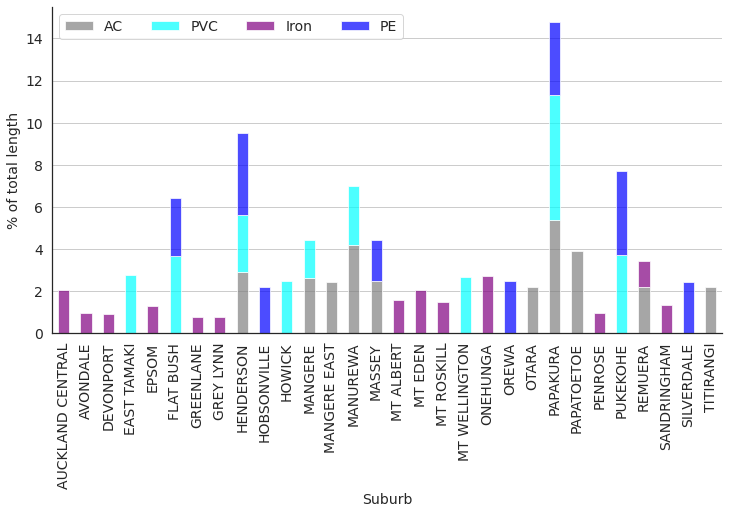

In [40]:
getBarPercentageSubUrbMaterials(inSerithAddress.copy())

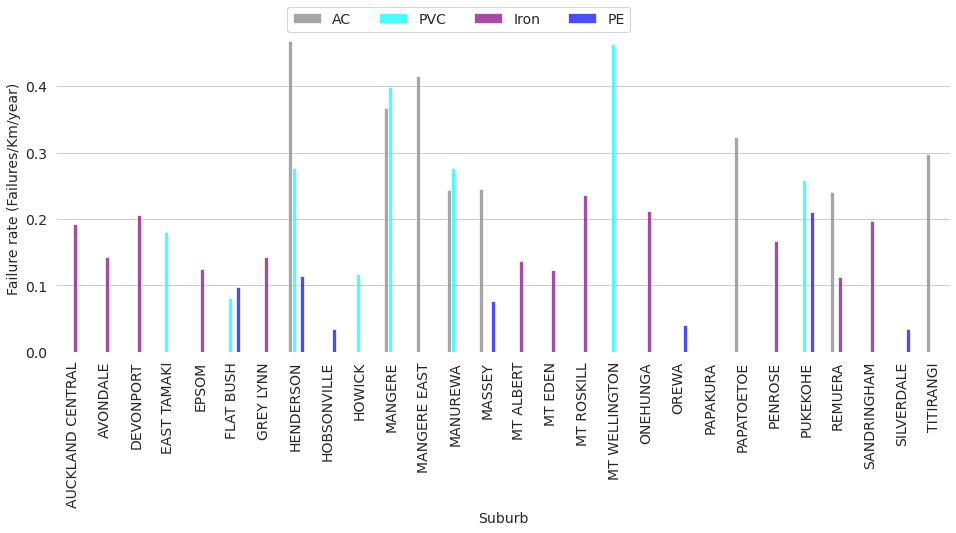

In [57]:
def getBurstRateVsSuburb(df):

    subUrbGroup = getGroupBySubUrb(df)
    
    materialsColumns = subUrbGroup.reset_index().pivot(index=SUBURB, columns=MATERIAL, values='Failures/Km/year')

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(16,6))

    ax = materialsColumns.plot.bar(ax= ax, color=pal, rot=90, alpha=0.7)
    ax = removeTopRightFrame(ax)
    
    ax.grid(axis='y', which='both')
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('Failure rate (Failures/Km/year)')
    ax.legend(ncol=4, facecolor='white',fontsize=14,loc='upper left', bbox_to_anchor=(.25, 1.08))
  
    

    fig1.savefig('Maps_Graph/SuburbAnalysis/'+'BurstRateVsSuburb' +'.png', dpi=200, bbox_inches='tight')


getBurstRateVsSuburb(predoWithAddress)